In [2]:
import numpy as np
import pandas as pd

In [3]:
dataset_dir = "datasets"

train_file = 'news_traindata'
train_nrows = 110000 * 0.9
train_df = pd.read_csv(f'{dataset_dir}/{train_file}.csv', encoding='utf-8', nrows=train_nrows)
train_df = train_df.dropna()

test_file = 'news_testdata'
test_nrows = 110000 * 0.1
test_df = pd.read_csv(f'{dataset_dir}/{test_file}.csv', encoding='utf-8', nrows=test_nrows)
test_df = test_df.dropna()

vocab_file = f'vocabs/vokab_{train_file}_{train_nrows}.pkl'
model_file = f"models/primary_model_{train_file}_{train_nrows}.pth"
encoded_testfile = f"encoded/primary_{test_file}_{test_nrows}.pt"
encoded_trainfile = f"encoded/primary``_{train_file}_{train_nrows}.pt"


In [4]:
train_df['content'] = train_df['title'].fillna('') + ' ' + train_df['content'].fillna('')
test_df['content'] = test_df['title'].fillna('') + ' ' + test_df['content'].fillna('')

In [5]:
import os
import pickle
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from collections import Counter

MAX_VOCAB = 50000
special_tokens = ['<unk>', '<pad>']
tokenizer = get_tokenizer('basic_english')


if os.path.exists(vocab_file):
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    print("Vocabulary loaded from 'vocab.pkl'.")

else:
    print("Vocab not found: ", vocab_file)

Vocabulary loaded from 'vocab.pkl'.


In [6]:

import torch
from torch.nn.utils.rnn import pad_sequence

MAX_LENGTH = 4096

if os.path.exists(encoded_testfile):
    data = torch.load(encoded_testfile)
    test_encoded_texts = data['inputs']
    test_labels = data['labels']
else:
    print("Encoded file not found: ", encoded_testfile)

In [14]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


val_ds = NewsDataset(test_encoded_texts, test_labels)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=0)

In [15]:
from mulstage_model import CNN_BiLSTM
from torch import nn


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

model = CNN_BiLSTM(vocab=vocab, vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=1, pad_idx=vocab['<pad>'])
model.to(device)


criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)   

model.load_state_dict(torch.load(model_file, map_location=device))

Using device: mps


<All keys matched successfully>

In [16]:
def evaluate(model, loader):
    model.eval()
    total_acc = 0

    preds_list = []
    actuals_list = []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            preds_class = (preds > 0.5).float()
            preds_list.append(preds_class.cpu().numpy())
            actuals_list.append(yb.cpu().numpy())
            total_acc += (preds_class == yb).float().mean().item()
    return total_acc / len(loader), preds_list, actuals_list

test_acc, preds_list, actuals_list = evaluate(model, val_dl)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.9863


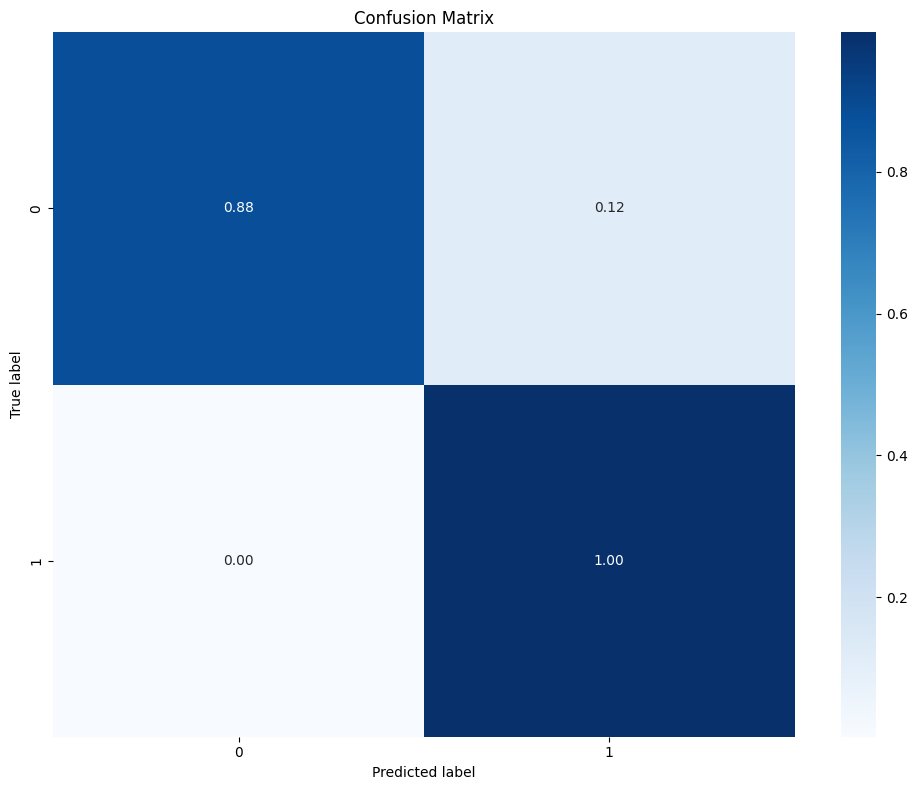

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    # Ensure input is NumPy array
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(
    np.concatenate(actuals_list),
    np.concatenate(preds_list),
    classes=[0, 1],
    normalize=True
)